In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
db=pd.read_csv('/content/sample_data/dataset.csv',encoding='ISO-8859-1')
db

,Rank,Name,No. of FTE Students,No. of students per staff,International Students,Female:Male Ratio
0,NaN,Country/Region,NaN,NaN,NaN,NaN
1,Reporter,Zarqa University,"5,768",18.1,32%,47:53:00
2,NaN,Jordan,NaN,NaN,NaN,NaN
3,Reporter,Ziauddin University,"4,906",8.8,1%,63:37:00
4,NaN,Pakistan,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
4872,NaN,United Kingdom,NaN,NaN,NaN,NaN
4873,2,Harvard University,"21,887",9.6,25%,50:50:00
4874,NaN,United States,NaN,NaN,NaN,NaN
4875,1,University of Oxford,"20,965",10.6,42%,48:52:00


В датасете присутствуют NaN строки, в одном столбце находятся разные параметры, нужно провести обработку данных

In [ ]:
db.drop(labels=0, inplace=True)
db.reset_index(inplace=True, drop=True)
def find_irregularity(db,full=False):
    prev=-1
    sum=0
    for index, row in db.iterrows():
        if pd.isna(row['Rank']):
            if index-prev!=2:
                sum+=1
                if sum<3 or full==True:
                    print('-------------------------')
                    print(f'Внимание, появилась неоднородность в данных')
                    for i in range(index-2,index+3):
                        print(i,db['Rank'].iloc[i],db['Name'].iloc[i], index-prev)
            prev=index
    print(f"---------------------\nКол-во неодноровностей:{sum}")
    if sum==0:
        print(f"Congrats, all clear!")
find_irregularity(db)

-------------------------
Внимание, появилась неоднородность в данных
38 Reporter Western Caspian University 1
39 nan Azerbaijan 1
40 nan Explore 1
41 Reporter ?Wellspring University 1
42 nan Nigeria 1
-------------------------
Внимание, появилась неоднородность в данных
67 Reporter National University of Uzbekistan named after Mirzo Ulugbek 1
68 nan Uzbekistan 1
69 nan Explore 1
70 Reporter University of Uyo 1
71 nan Nigeria 1
---------------------
Кол-во неодноровностей:186


Имеется неоднородность в данных. В одном столбце находятся и названия университетов, и их страны. Уберем лишние строки Explore

In [ ]:
db=db[db['Name']!='Explore']
db.reset_index(inplace=True, drop=True)
find_irregularity(db, full=True)

-------------------------
Внимание, появилась неоднородность в данных
2346 10011200 St Marianna University School of Medicine 1
2347 nan Japan 1
2348 nan Not accredited 1
2349 10011200 ?tefan cel Mare University of Suceava 1
2350 nan Romania 1
---------------------
Кол-во неодноровностей:1


Осталась только одна неоднородность

In [ ]:
db.iloc[2345:2351]

,Rank,Name,No. of FTE Students,No. of students per staff,International Students,Female:Male Ratio
2345,NaN,United Kingdom,NaN,NaN,NaN,NaN
2346,10011200,St Marianna University School of Medicine,833,0.9,1%,39 : 61
2347,NaN,Japan,NaN,NaN,NaN,NaN
2348,NaN,Not accredited,NaN,NaN,NaN,NaN
2349,10011200,?tefan cel Mare University of Suceava,"9,239",24.8,14%,59:41:00
2350,NaN,Romania,NaN,NaN,NaN,NaN


Разобравшись с причиной такой неоднородности, я пришел к выводу что скорее всего данный университет не аккредитован. Поэтому просто избавлюсь от всех похожих строк.

In [ ]:
db=db[db['Name']!='Not accredited']
db.reset_index(inplace=True, drop=True)
find_irregularity(db, full=True)

---------------------
Кол-во неодноровностей:0
Congrats, all clear!


In [ ]:
countries=[]
indexes=[]
for index, row in db.iterrows():
    if index%2==1:
        countries.append(row['Name'])
        indexes.append(index)
db.drop(labels=indexes, inplace=True)
db.reset_index(inplace=True, drop=True)

In [ ]:
db.insert(2,'Country',countries)
db

,Rank,Name,Country,No. of FTE Students,No. of students per staff,International Students,Female:Male Ratio
0,Reporter,Zarqa University,Jordan,"5,768",18.1,32%,47:53:00
1,Reporter,Ziauddin University,Pakistan,"4,906",8.8,1%,63:37:00
2,Reporter,Zhytomyr Polytechnic State University,Ukraine,"3,869",15.4,1%,34 : 66
3,Reporter,"Yusuf Maitama Sule University, Kano",Nigeria,"12,880",33.0,0%,48:52:00
4,Reporter,York St John University,United Kingdom,"6,315",18.6,12%,65:35:00
...,...,...,...,...,...,...,...
2340,5,Massachusetts Institute of Technology,United States,"11,415",8.2,33%,40 : 60
2341,3,Stanford University,United States,"16,164",7.1,24%,46:54:00
2342,3,University of Cambridge,United Kingdom,"20,185",11.3,39%,47:53:00
2343,2,Harvard University,United States,"21,887",9.6,25%,50:50:00


Некоторые значения в тексте выглядят странно, а именно в столбце No fo FTE Students, что значит количество студентов обучающихся в классическом режиме (Очно/Заочно), написаны с запятой а не с точкой, именно поэтому числа не воспринимаются впринципе как числа.

In [ ]:
db.dtypes

,0
Rank,object
Name,object
Country,object
No. of FTE Students,object
No. of students per staff,float64
International Students,object
Female:Male Ratio,object


In [ ]:
db["No. of FTE Students"]=db["No. of FTE Students"].str.replace(',','.')
db["No. of FTE Students"]= db["No. of FTE Students"].astype(float)
print(db['No. of FTE Students'])

0        5.768
1        4.906
2        3.869
3       12.880
4        6.315
         ...  
2340    11.415
2341    16.164
2342    20.185
2343    21.887
2344    20.965
Name: No. of FTE Students, Length: 2345, dtype: float64


In [ ]:
db[db["International Students"]=='']

,Rank,Name,Country,No. of FTE Students,No. of students per staff,International Students,Female:Male Ratio


In [ ]:
db.drop(labels=[371,483,1471],inplace=True)
db.reset_index(inplace=True, drop=True)

In [ ]:
db["International Students"]=db["International Students"].str.replace('%','')
db["International Students"]= db["International Students"].astype(float)
db["International Students"]= db["International Students"].apply(lambda x : x/100)
print(db['International Students'])

0       0.32
1       0.01
2       0.01
3       0.00
4       0.12
        ... 
2337    0.33
2338    0.24
2339    0.39
2340    0.25
2341    0.42
Name: International Students, Length: 2342, dtype: float64


In [ ]:
db

,Rank,Name,Country,No. of FTE Students,No. of students per staff,International Students,Female:Male Ratio
0,Reporter,Zarqa University,Jordan,5.768,18.1,0.32,47:53:00
1,Reporter,Ziauddin University,Pakistan,4.906,8.8,0.01,63:37:00
2,Reporter,Zhytomyr Polytechnic State University,Ukraine,3.869,15.4,0.01,34 : 66
3,Reporter,"Yusuf Maitama Sule University, Kano",Nigeria,12.880,33.0,0.00,48:52:00
4,Reporter,York St John University,United Kingdom,6.315,18.6,0.12,65:35:00
...,...,...,...,...,...,...,...
2337,5,Massachusetts Institute of Technology,United States,11.415,8.2,0.33,40 : 60
2338,3,Stanford University,United States,16.164,7.1,0.24,46:54:00
2339,3,University of Cambridge,United Kingdom,20.185,11.3,0.39,47:53:00
2340,2,Harvard University,United States,21.887,9.6,0.25,50:50:00


In [ ]:
null_index=list(db[db['Female:Male Ratio'].isnull()].index)

for index, row in db.iterrows():
    ratio=db['Female:Male Ratio'][index]
    if index not in (null_index):
        ratio=ratio.replace(' ','')
        ratio=ratio.split(':')
        if len(ratio)==3:
            ratio.pop(-1)
        if len(ratio)==2:
            a=int(ratio[0])
            b=int(ratio[1])
            if b!=0:
                ratio[0]=float(a/b)
            else:
                ratio[0]=100.
            ratio.pop(-1)
        ratio=float(ratio[0])
        db.loc[index,'Female:Male Ratio']=ratio
        # print(ratio)
db['Female:Male Ratio'] = db['Female:Male Ratio'].fillna(db['Female:Male Ratio'].mean())

<ipython-input-16-90e012c3e4d6>:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  db['Female:Male Ratio'] = db['Female:Male Ratio'].fillna(db['Female:Male Ratio'].mean())


In [ ]:
print(set(db['Rank']))

{'111', '23', '401\x96500', '174', '40', '53', '31', '136', '196', '6', '106', '601\x96800', '10', '14', '251\x96300', '170', '48', '7', '19', '186', '351\x96400', '133', '52', '185', '89', '198', '81', '79', '163', '88', '161', '166', '118', '35', '146', '22', '144', '130', '73', '68', '63', 'Reporter', '117', '17', '801\x961000', '126', '191', '64', '148', '1', '101', '85', '38', '66', '58', '42', '192', '122', '107', '175', '124', '59', '182', '1001\x961200', '36', '187', '114', '70', '39', '137', '33', '160', '51', '26', '54', '180', '65', '123', '60', '93', '76', '99', '501\x96600', '57', '18', '134', '112', '145', '71', '30', '301\x96350', '50', '179', '80', '173', '181', '37', '67', '69', '13', '128', '86', '45', '49', '82', '74', '113', '2', '108', '78', '189', '110', '135', '194', '62', '155', '139', '94', '75', '1201\x961500', '44', '98', '147', '1501+', '11', '3', '90', '24', '20', '91', '41', '34', '28', '16', '156', '154', '46', '168', '43', '131', '176', '121', '21', '9',

In [ ]:
size=len(db.index)

index_report=list(db[db['Rank']=='Reporter'].index) # That will help us soon.

for i in range(size):
    db.loc[i,'Rank']=size-i

db['Rank']=db['Rank'].astype(int)
print(db['Rank'])

0       2342
1       2341
2       2340
3       2339
4       2338
        ... 
2337       5
2338       4
2339       3
2340       2
2341       1
Name: Rank, Length: 2342, dtype: int64


In [ ]:
print(db.dtypes)

Rank                           int64
Name                          object
Country                       object
No. of FTE Students          float64
No. of students per staff    float64
International Students       float64
Female:Male Ratio            float64
dtype: object


In [ ]:
print(db.isnull().any())

Rank                         False
Name                         False
Country                      False
No. of FTE Students          False
No. of students per staff    False
International Students       False
Female:Male Ratio            False
dtype: bool


<Axes: >

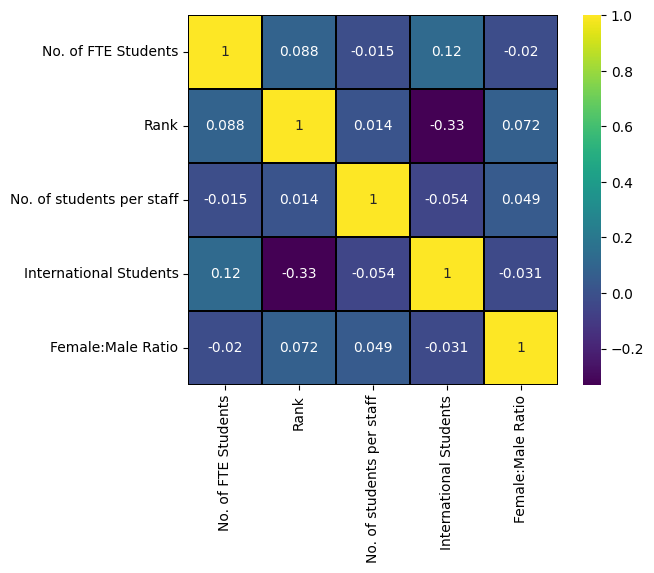

In [ ]:
sns.heatmap(db[['No. of FTE Students','Rank','No. of students per staff','International Students','Female:Male Ratio']].corr(),linewidths=0.25,vmax=1.0, square=True, cmap="viridis", linecolor='k', annot=True)

Text(0.5, 1.0, 'Зависимость места в рейтинге от доли иностранных студентов')

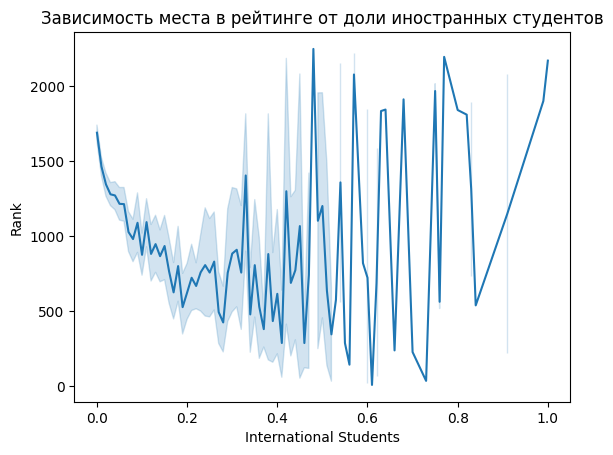

In [ ]:
plot=sns.lineplot(x="International Students", y="Rank",data=db)
plot.set_title('Зависимость места в рейтинге от доли иностранных студентов')

In [ ]:
print(index_report)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Text(0.5, 1.0, 'Зависимость места в рейтинге от доли иностранных студентов')

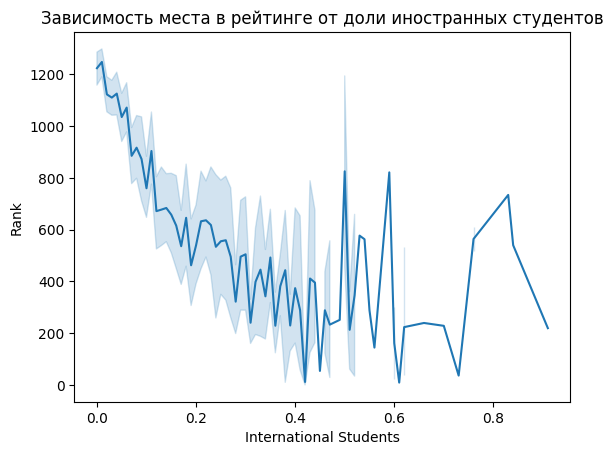

In [ ]:
plot=sns.lineplot(x="International Students", y="Rank",data=db[db['Rank']<1800])
plot.set_title('Зависимость места в рейтинге от доли иностранных студентов')

In [ ]:
db.head()

,Rank,Name,Country,No. of FTE Students,No. of students per staff,International Students,Female:Male Ratio
0,2342,Zarqa University,Jordan,5.768,18.1,0.32,0.886792
1,2341,Ziauddin University,Pakistan,4.906,8.8,0.01,1.702703
2,2340,Zhytomyr Polytechnic State University,Ukraine,3.869,15.4,0.01,0.515152
3,2339,"Yusuf Maitama Sule University, Kano",Nigeria,12.880,33.0,0.00,0.923077
4,2338,York St John University,United Kingdom,6.315,18.6,0.12,1.857143


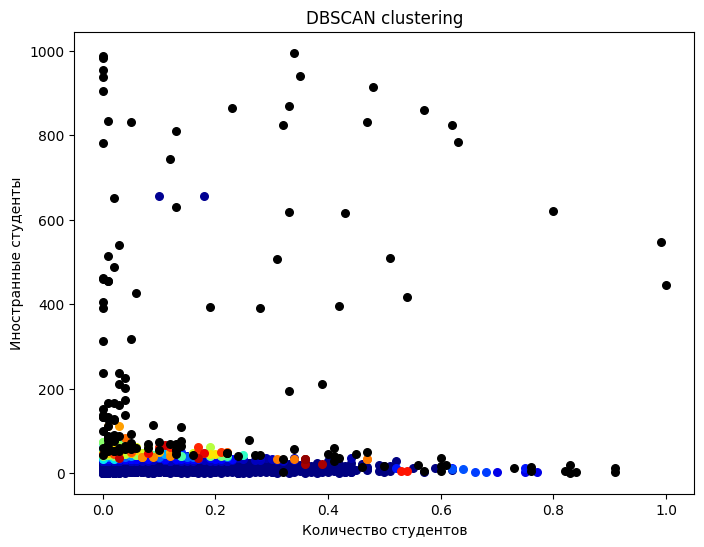

In [ ]:
X = db[['International Students', 'No. of FTE Students']].values

dbscan = DBSCAN(eps=0.2, min_samples=2)
labels = dbscan.fit_predict(X)


plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:

        col = 'k'

    class_member_mask = (labels == k)


    xy = X[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=30, color=col, label=f'Cluster {k}')

plt.title('DBSCAN clustering')
plt.xlabel('Количество студентов')
plt.ylabel('Иностранные студенты')
plt.show()

Mean Squared Error с использованием кросс-валидации: 0.017637309378282413


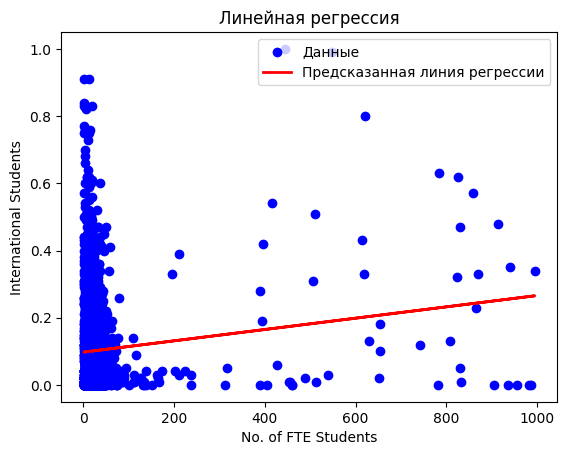

Коэффициент: 0.0001684897836027053
Свободный член: 0.09752987446393716


In [ ]:
X = db[['No. of FTE Students']].values
y = db['International Students'].values


model = LinearRegression()


scores = cross_val_score(model, X, y, cv=20, scoring='neg_mean_squared_error')


mean_mse = np.mean(-scores)
print(f'Mean Squared Error с использованием кросс-валидации: {mean_mse}')


model.fit(X, y)


y_pred = model.predict(X)


plt.scatter(X, y, color='blue', label='Данные')
plt.plot(X, y_pred, color='red', linewidth=2, label='Предсказанная линия регрессии')
plt.title('Линейная регрессия')
plt.xlabel('No. of FTE Students')
plt.ylabel('International Students')
plt.legend()
plt.show()


print(f'Коэффициент: {model.coef_[0]}')
print(f'Свободный член: {model.intercept_}')

Итерация 1: Mean Squared Error = 0.028355045752545487
Итерация 2: Mean Squared Error = 0.026115606005259116
Итерация 3: Mean Squared Error = 0.02745999682279004
Итерация 4: Mean Squared Error = 0.026993244849005133
Итерация 5: Mean Squared Error = 0.026661271109834673
Итерация 6: Mean Squared Error = 0.027734210652858856
Итерация 7: Mean Squared Error = 0.027821141683481456
Итерация 8: Mean Squared Error = 0.027530565101907278
Итерация 9: Mean Squared Error = 0.027214132410317712
Итерация 10: Mean Squared Error = 0.026516157116843554
Итерация 11: Mean Squared Error = 0.02704719764360644
Итерация 12: Mean Squared Error = 0.027541440099443593
Итерация 13: Mean Squared Error = 0.027256260476743784
Итерация 14: Mean Squared Error = 0.027634447897609524
Итерация 15: Mean Squared Error = 0.02696381011331858
Итерация 16: Mean Squared Error = 0.027366507160582615
Итерация 17: Mean Squared Error = 0.026608007266619514
Итерация 18: Mean Squared Error = 0.027864264259430588
Итерация 19: Mean Squa

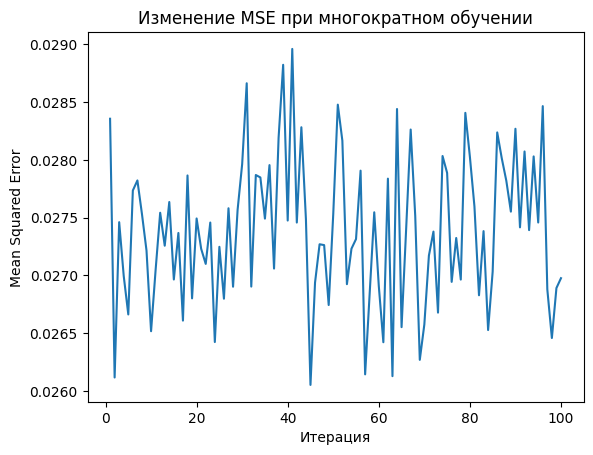

In [ ]:
num_iterations = 100
scores = []


model = LinearRegression()


original_X = X.copy()
original_y = y.copy()

for i in range(num_iterations):

    noise_X = np.random.normal(0, 0.1, original_X.shape)
    noise_y = np.random.normal(0, 0.1, original_y.shape)


    noisy_X = original_X + noise_X
    noisy_y = original_y + noise_y


    mse_score = -cross_val_score(model, noisy_X, noisy_y, cv=100, scoring='neg_mean_squared_error').mean()
    scores.append(mse_score)
    print(f'Итерация {i + 1}: Mean Squared Error = {mse_score}')


plt.plot(range(1, num_iterations + 1), scores)
plt.xlabel('Итерация')
plt.ylabel('Mean Squared Error')
plt.title('Изменение MSE при многократном обучении')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [ ]:
rf_predictions = rf_model.predict(X_test)
gb_predictions = gb_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))

print(f'Random Forest RMSE: {rf_rmse}')
print(f'Gradient Boosting RMSE: {gb_rmse}')

Random Forest RMSE: 0.15455733571405475
Gradient Boosting RMSE: 0.12865368608606187


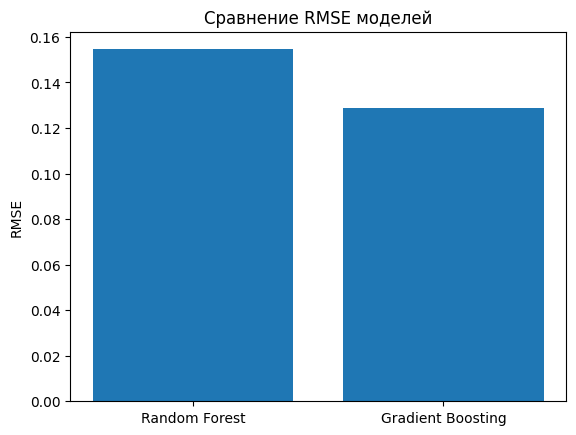

In [ ]:
models = ['Random Forest', 'Gradient Boosting']
rmse_values = [rf_rmse, gb_rmse]

plt.bar(models, rmse_values)
plt.ylabel('RMSE')
plt.title('Сравнение RMSE моделей')
plt.show()

In [ ]:
rf_model.n_estimators += 50

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

In [ ]:
gb_model = GradientBoostingRegressor(n_estimators=100, warm_start=True)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(warm_start=True)

In [ ]:
gb_model.n_estimators += 50
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=150, warm_start=True)

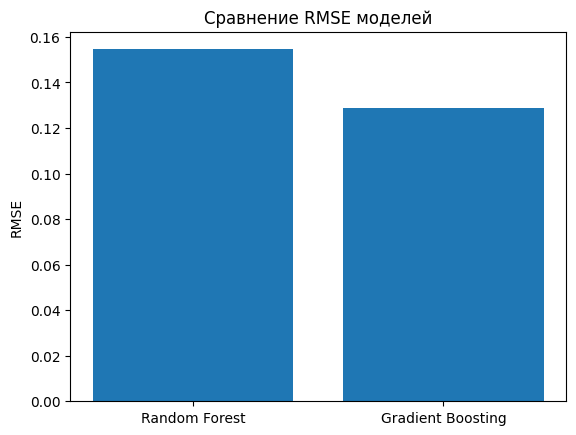

In [ ]:
models = ['Random Forest', 'Gradient Boosting']
rmse_values = [rf_rmse, gb_rmse]

plt.bar(models, rmse_values)
plt.ylabel('RMSE')
plt.title('Сравнение RMSE моделей')
plt.show()

In [ ]:
num_iterations = 10
scores = []

model = rf_model

original_X = X.copy()
original_y = y.copy()

for i in range(num_iterations):
    mse_score = -cross_val_score(model, original_X, original_y, cv=100, scoring='neg_mean_squared_error').mean()
    scores.append(mse_score)
    print(f'Итерация {i + 1}: Mean Squared Error = {mse_score}')

plt.plot(range(1, num_iterations + 1), scores)
plt.xlabel('Итерация')
plt.ylabel('Mean Squared Error')
plt.title('Изменение MSE при многократном обучении')
plt.show()

KeyboardInterrupt: 

Mean Squared Error (MSE): 0.0239
R-squared (R2): -0.4622


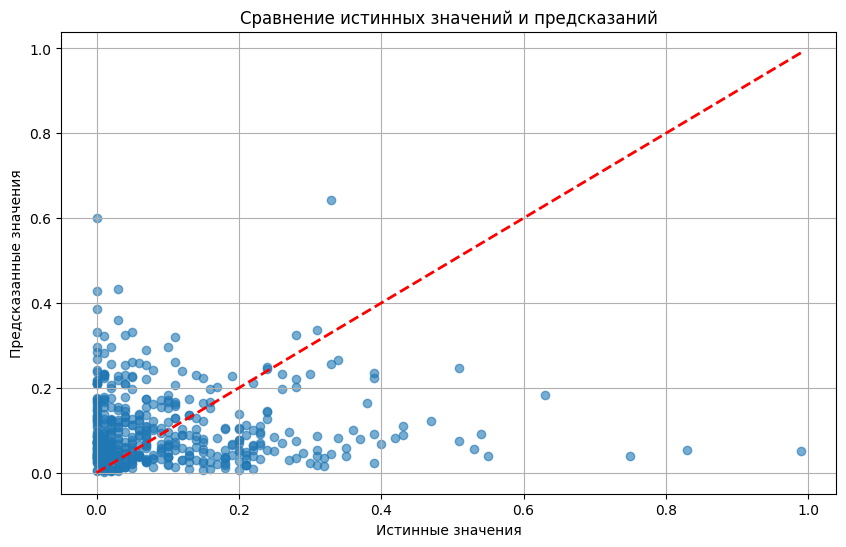

In [ ]:
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Сравнение истинных значений и предсказаний')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.grid()
plt.show()

In [ ]:

features = db[['No. of FTE Students', 'International Students', 'Female:Male Ratio']]
target = db['Rank']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))


model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

model.fit(X_train, y_train, epochs=500, batch_size=10, validation_split=0.2)

Epoch 1/500
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 303561.9688 - val_loss: 298189.6562
Epoch 2/500
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 302657.1875 - val_loss: 298657.1250
Epoch 3/500
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 317545.0312 - val_loss: 297540.0000
Epoch 4/500
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 302925.0000 - val_loss: 299204.3438
Epoch 5/500
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 295848.8750 - val_loss: 297532.7500
Epoch 6/500
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 303828.6562 - val_loss: 299303.7188
Epoch 7/500
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 300166.9375 - val_loss: 297227.6875
Epoch 8/500
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 305362.5625 - val_loss: 297262.5938
Epoch 9/500
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 296173.8125 - val_loss: 296073.9688
Epoch 10/500
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 302838.1562 - val_loss: 295509.1250
Epoch 11/500
150/150 ━━━━━━━━

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 259028.1562
Test Loss: 279262.125


In [ ]:
predictions = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 284929.0625 - val_loss: 283113.7500
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 284919.4062 - val_loss: 282054.6875
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 268719.4688 - val_loss: 284026.4062
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 278553.5000 - val_loss: 283232.6250
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 279121.9688 - val_loss: 282970.2812
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 270853.4062 - val_loss: 281848.3438
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 277691.8438 - val_loss: 285383.0000
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 289639.0000 - val_loss: 283201.5938
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 278202.4688 - val_loss: 281221.0938
Epoch 10/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 273165.8750 - val_loss: 282852.6250
Epoch 11/100
150/150 ━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

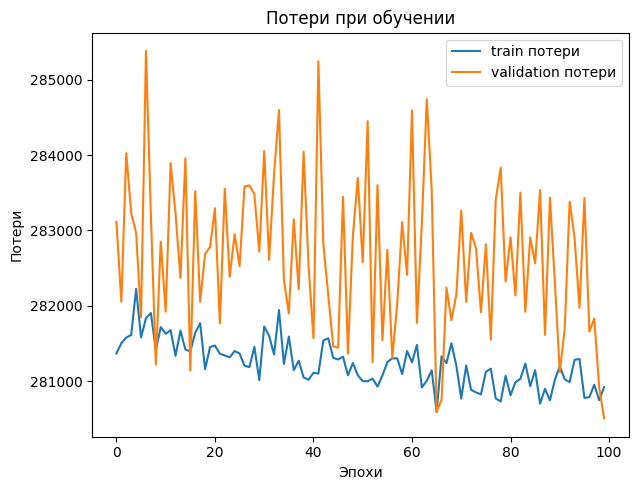

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train потери')
plt.plot(history.history['val_loss'], label='validation потери')
plt.title('Потери при обучении')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()


if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


predictions = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


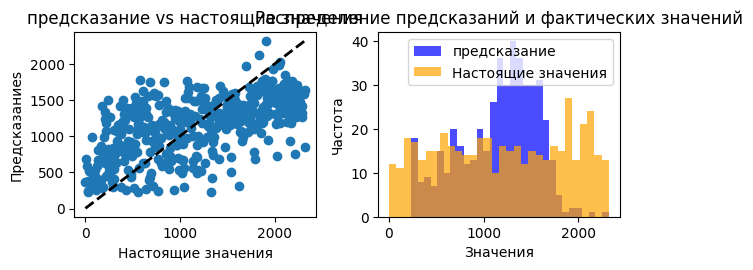

In [ ]:
predictions = model.predict(X_test)
plt.subplot(2, 2, 3)
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('предсказание vs настоящие значения')
plt.xlabel('Настоящие значения')
plt.ylabel('Предсказаниеs')


plt.subplot(2, 2, 4)
plt.hist(predictions, bins=30, alpha=0.7, label='предсказание', color='blue')
plt.hist(y_test, bins=30, alpha=0.7, label='Настоящие значения', color='orange')
plt.title('Распределение предсказаний и фактических значений')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()

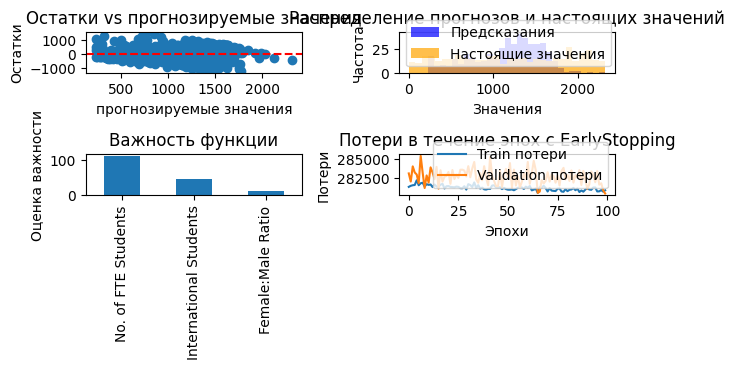

In [ ]:
residuals = y_test - predictions.flatten()
plt.subplot(3, 2, 3)
plt.scatter(predictions, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки vs прогнозируемые значения')
plt.xlabel('прогнозируемые значения')
plt.ylabel('Остатки')


plt.subplot(3, 2, 4)
plt.hist(predictions, bins=30, alpha=0.7, label='Предсказания', color='blue')
plt.hist(y_test, bins=30, alpha=0.7, label='Настоящие значения', color='orange')
plt.title('Распределение прогнозов и настоящих значений')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.legend()


importance = np.abs(model.layers[0].get_weights()[0]).sum(axis=1)
feature_importance = pd.Series(importance, index=features.columns).sort_values(ascending=False)

plt.subplot(3, 2, 5)
feature_importance.plot(kind='bar')
plt.title('Важность функции')
plt.ylabel('Оценка важности')


plt.subplot(3, 2, 6)
plt.plot(history.history['loss'], label='Train потери')
plt.plot(history.history['val_loss'], label='Validation потери')
plt.title('Потери в течение эпох с EarlyStopping')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.tight_layout()
plt.show()